<a href="https://colab.research.google.com/github/MohammadAliAfsahi/AdclickPrediction/blob/master/DataDays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls '/content/drive/My Drive/datadays2020_contest_public_dataset'

ad.csv	      click_test.csv   page.csv
ad_image.csv  click_train.csv  page_topic.csv
ad_title.csv  event.csv        user_page_view.csv


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import ast
import pandas as pd

In [0]:
path = '/content/drive/My Drive/datadays2020_contest_public_dataset/'

advertisements = pd.read_csv(path + 'ad.csv')
advertisements_images = pd.read_csv(path + 'ad_image.csv')
advertisements_titles = pd.read_csv(path + 'ad_title.csv')
clicked_train = pd.read_csv(path + 'click_train.csv')
event = pd.read_csv(path + 'event.csv')
page = pd.read_csv(path + 'page.csv')
page_topic = pd.read_csv(path + 'page_topic.csv')
user_views = pd.read_csv(path + 'user_page_view.csv')

click_test = pd.read_csv(path + 'click_test.csv')

In [5]:
advertisements.head()

,adId,campaignId,advertiserId
0,7867,5918,8414
1,7866,5918,8414
2,7865,5918,8414
3,7863,8343,8414
4,7862,8343,8414


In [22]:
advertisements.isna().sum()

adId            0
campaignId      0
advertiserId    0
dtype: int64

In [6]:
print("# of unique advertisements : ", advertisements.loc[:, 'adId'].nunique())
print("# of unique campaigns : ", advertisements.loc[:, 'campaignId'].nunique())
print("# of unique advertisers : ", advertisements.loc[:, 'advertiserId'].nunique())

# of unique advertisements :  3256
# of unique campaigns :  528
# of unique advertisers :  213


In [7]:
advertisements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3256 entries, 0 to 3255
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   adId          3256 non-null   int64
 1   campaignId    3256 non-null   int64
 2   advertiserId  3256 non-null   int64
dtypes: int64(3)
memory usage: 76.4 KB


In [8]:
advertisements.describe()

,adId,campaignId,advertiserId
count,3256.000000,3256.000000,3256.000000
mean,5624.645577,4958.381757,5638.853194
std,1957.739025,2678.464798,2722.979337
min,6.000000,30.000000,1.000000
25%,5220.750000,2664.750000,3137.000000
50%,6150.500000,5095.000000,6572.000000
75%,6994.250000,7270.000000,8078.000000
max,7867.000000,9523.000000,10749.000000


In [9]:
advertisements_images.head()

,adId,imageFeatures
0,7867,"[0.0524589940905571, 0.0, 0.04262353479862213,..."
1,7866,"[0.0032160670962184668, 0.1444239318370819, 0...."
2,7865,"[0.027210379019379616, 0.0, 0.5133526921272278..."
3,7863,"[0.0013980235671624541, 0.0, 0.0, 0.0455568209..."
4,7862,"[0.02426762878894806, 0.026081759482622147, 0...."


In [23]:
advertisements_images.isna().sum()

adId             0
imageFeatures    0
dtype: int64

In [0]:
advertisements_images['image'] = advertisements_images.apply(lambda x: ast.literal_eval(x['imageFeatures']), axis=1)
advertisements_images['imageFeatures'] = advertisements_images['image']
advertisements_images.drop('image', axis=1, inplace=True)

In [11]:
advertisements_titles.head()

,adId,wordId
0,6,24
1,6,25
2,6,26
3,6,27
4,6,28


In [24]:
advertisements_titles.isna().sum()

adId      0
wordId    0
dtype: int64

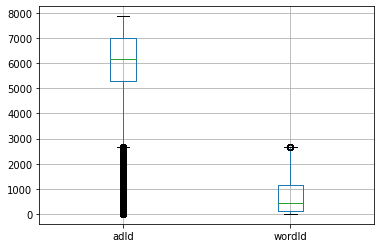

In [12]:
advertisements_titles.boxplot(column=['adId', 'wordId'])

In [13]:
clicked_train.head()

,displayId,adId,clicked
0,1210227,7182,0
1,1210227,7125,0
2,1210227,7181,0
3,1210227,535,0
4,1210227,7174,1


In [25]:
clicked_train.isna().sum()

displayId    0
adId         0
clicked      0
dtype: int64

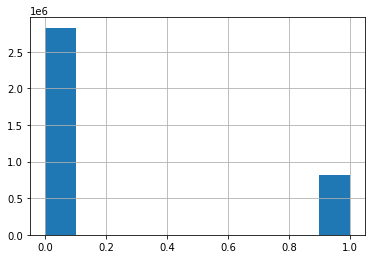

In [14]:
clicked_train['clicked'].hist()

In [15]:
event.head()

,displayId,timestamp,pageId,widgetId,userId,device,OS,browser
0,4706262,1578429005696,3543873,6262,2688642,0,0,0
1,4706267,1578429007726,6245475,607,2688641,1,3,0
2,4706260,1578429012060,4416499,11458,2688638,0,0,1
3,4706255,1578429017218,6246028,9358,1962852,0,0,0
4,4706256,1578429021388,5327047,9358,2687719,0,0,0


In [26]:
event.isna().sum()

displayId    0
timestamp    0
pageId       0
widgetId     0
userId       0
device       0
OS           0
browser      0
dtype: int64

In [16]:
event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083071 entries, 0 to 1083070
Data columns (total 8 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   displayId  1083071 non-null  int64
 1   timestamp  1083071 non-null  int64
 2   pageId     1083071 non-null  int64
 3   widgetId   1083071 non-null  int64
 4   userId     1083071 non-null  int64
 5   device     1083071 non-null  int64
 6   OS         1083071 non-null  int64
 7   browser    1083071 non-null  int64
dtypes: int64(8)
memory usage: 66.1 MB


In [19]:
page.head()

,pageId,website,publisher
0,1,0,0
1,3,1,1
2,4,2,2
3,5,3,3
4,6,4,4


In [27]:
page.isna().sum()

pageId       0
website      0
publisher    0
dtype: int64

In [20]:
page_topic.head()

,pageId,topicId,confidence
0,10743259,37,0.497099
1,10743259,23,0.016994
2,10743259,10,0.371499
3,10743259,4,0.105349
4,10743258,33,0.245752


In [28]:
page_topic.isna().sum()

pageId        0
topicId       0
confidence    0
dtype: int64

In [21]:
user_views.head()

,userId,pageId,timestamp
0,821961,8116,1579599211445
1,15321,9533442,1579599211443
2,1125090,9410379,1579599211440
3,407101,8616213,1579599211429
4,781615,9543366,1579599211429


In [29]:
user_views.isna().sum()

userId       0
pageId       0
timestamp    0
dtype: int64

In [0]:
main = pd.merge(advertisements, advertisements_images, on='adId')

In [0]:
main = pd.merge(main, advertisements_titles, on='adId')

In [0]:
main = pd.merge(main, clicked_train, on='adId')

In [0]:
main = pd.merge(main, event, on='displayId')

In [0]:
main = pd.merge(main, page, on='pageId')

In [0]:
main = pd.merge(main, page_topic, on='pageId')

In [0]:
main = pd.merge(main, user_views, on='userId')

In [0]:
main.isna().sum()

In [0]:
main.describe()

In [0]:
main.head(10)

,adId,campaignId,advertiserId,imageFeatures,wordId,displayId,clicked,timestamp,pageId,widgetId,userId,device,OS,browser,website,publisher,topicId,confidence
0,7182,3402,7579,"[0.17772938311100006, 0.6273877620697021, 0.55...",108,1210227,0,1579598863403,420857,9519,782749,0,0,1,477,49,38,0.047635
1,7182,3402,7579,"[0.17772938311100006, 0.6273877620697021, 0.55...",108,1210227,0,1579598863403,420857,9519,782749,0,0,1,477,49,30,0.214971
2,7182,3402,7579,"[0.17772938311100006, 0.6273877620697021, 0.55...",108,1210227,0,1579598863403,420857,9519,782749,0,0,1,477,49,22,0.108900
3,7182,3402,7579,"[0.17772938311100006, 0.6273877620697021, 0.55...",108,1210227,0,1579598863403,420857,9519,782749,0,0,1,477,49,20,0.316218
4,7182,3402,7579,"[0.17772938311100006, 0.6273877620697021, 0.55...",108,1210227,0,1579598863403,420857,9519,782749,0,0,1,477,49,18,0.055987
5,7182,3402,7579,"[0.17772938311100006, 0.6273877620697021, 0.55...",108,1210227,0,1579598863403,420857,9519,782749,0,0,1,477,49,13,0.152800
6,7182,3402,7579,"[0.17772938311100006, 0.6273877620697021, 0.55...",108,1210227,0,1579598863403,420857,9519,782749,0,0,1,477,49,9,0.019889
7,7182,3402,7579,"[0.17772938311100006, 0.6273877620697021, 0.55...",108,1210227,0,1579598863403,420857,9519,782749,0,0,1,477,49,1,0.078198
8,7182,3402,7579,"[0.17772938311100006, 0.6273877620697021, 0.55...",675,1210227,0,1579598863403,420857,9519,782749,0,0,1,477,49,38,0.047635
9,7182,3402,7579,"[0.17772938311100006, 0.6273877620697021, 0.55...",675,1210227,0,1579598863403,420857,9519,782749,0,0,1,477,49,30,0.214971


In [0]:
main.drop_duplicates(inplace=True)

In [0]:
len(main)

71074287

In [0]:
main = pd.merge(clicked_train, event, on='displayId')

In [0]:
main.loc[main.displayId == 1210227]

,displayId,adId,clicked,timestamp,pageId,widgetId,userId,device,OS,browser
0,1210227,7182,0,1579598863403,420857,9519,782749,0,0,1
1,1210227,7125,0,1579598863403,420857,9519,782749,0,0,1
2,1210227,7181,0,1579598863403,420857,9519,782749,0,0,1
3,1210227,535,0,1579598863403,420857,9519,782749,0,0,1
4,1210227,7174,1,1579598863403,420857,9519,782749,0,0,1


In [0]:
main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3642244 entries, 0 to 3642243
Data columns (total 10 columns):
displayId    int64
adId         int64
clicked      int64
timestamp    int64
pageId       int64
widgetId     int64
userId       int64
device       int64
OS           int64
browser      int64
dtypes: int64(10)
memory usage: 305.7 MB


In [0]:
main.isna().sum()

displayId    0
adId         0
clicked      0
timestamp    0
pageId       0
widgetId     0
userId       0
device       0
OS           0
browser      0
dtype: int64

In [0]:
REG = 10

keys = clicked_train.adId.value_counts().keys().tolist()
values = clicked_train.adId.value_counts().tolist()
toDict = dict(zip(keys, values))

probability_table = pd.DataFrame(columns=['adId', 'probability'])

In [0]:
for key, val in toDict.items():
  temp = clicked_train[clicked_train.adId == key]
  probability = len(temp[temp.clicked == 1]) / (len(temp) + REG)
  probability_table = probability_table.append({"adId": key, "probability": probability}, ignore_index=True)

In [0]:
probability_table.head()

,adId,probability
0,17.0,0.370849
1,5486.0,0.213572
2,535.0,0.294861
3,6515.0,0.221683
4,538.0,0.256662


In [0]:
answer = pd.merge(click_test, probability_table, on='adId')

In [0]:
answer['rank'] = answer['probability'].rank()
answer.head()

,displayId,adId,probability,rank
0,151650,6257,0.203549,273863.0
1,244340,6257,0.203549,273863.0
2,244398,6257,0.203549,273863.0
3,244965,6257,0.203549,273863.0
4,245234,6257,0.203549,273863.0


In [0]:
answer.drop(['probability'], axis=1)

,displayId,adId,rank
0,151650,6257,273863.0
1,244340,6257,273863.0
2,244398,6257,273863.0
3,244965,6257,273863.0
4,245234,6257,273863.0
...,...,...,...
804459,1327609,7168,62053.0
804460,1327627,7168,62053.0
804461,1327877,7168,62053.0
804462,1328140,7168,62053.0


In [0]:
answer.to_csv('answer.csv', index=False)

In [0]:
user_views_stats = user_views['timestamp'].describe()
user_views_stats

count    6.722982e+07
mean     1.579000e+12
std      3.399870e+08
min      1.578429e+12
25%      1.578721e+12
50%      1.578984e+12
75%      1.579313e+12
max      1.579599e+12
Name: timestamp, dtype: float64

In [0]:
from datetime import datetime
def convert_timestamps(timeStamp):
  return datetime.fromtimestamp(int(timeStamp) // 1000)

In [0]:
print(convert_timestamps(user_views_stats['min']))

2020-01-07 20:30:00


In [0]:
print(convert_timestamps(user_views_stats['max']))

2020-01-21 09:33:31


In [0]:
views = pd.DataFrame(event.pivot_table(index=['userId'], aggfunc='size'), columns=['count'])
views = pd.DataFrame(views.reset_index().groupby('count')['userId'].count()).reset_index()
views.rename(columns={'count': 'No.views', 'userId': 'userCount'}, inplace=True)

In [0]:
views.head()

,No.views,userCount
0,1,695721
1,2,104153
2,3,26886
3,4,9270
4,5,3768


In [0]:
distinct_users_count = views['userCount'].sum()
distinct_users_count

844374

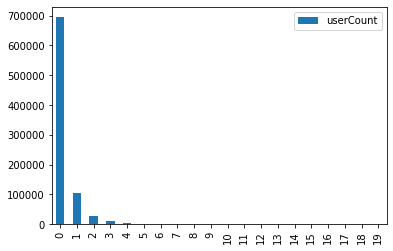

In [0]:
views.head(20).plot.bar(y='userCount')

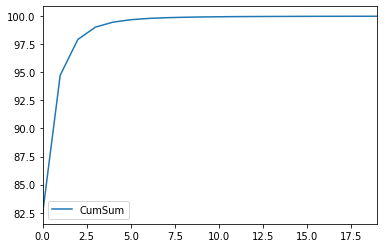

In [0]:
views['CumSum'] = (views['userCount'].cumsum() / distinct_users_count) * 100
views.head(20).plot.line(y='CumSum')